In [1]:
import javabridge
import os
import glob
import numpy as np
import pandas as pd
import pydot
from IPython.display import SVG

In [2]:
tetrad_libdir = os.path.join(os.getcwd(), '../../','src', 'pycausal', 'lib')
for l in glob.glob(tetrad_libdir + os.sep + "*.jar"):
    print (l)
    javabridge.JARS.append(str(l))

/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/tetrad-lib-6.4.0-SNAPSHOT-tetradcmd.jar
/home/jovyan/py-causal/example/javabridge/../../src/pycausal/lib/data-reader-0.2.3-SNAPSHOT.jar


In [3]:
javabridge.start_vm(run_headless=True, max_heap_size = '100M')
javabridge.attach()

In [4]:
data_dir = os.path.join(os.getcwd(), '../../','data', 'charity.txt')
data_dir

'/home/jovyan/py-causal/example/javabridge/../../data/charity.txt'

In [5]:
dframe = pd.read_table(data_dir, sep="\t")
dframe.head()

,TangibilityCondition,AmountDonated,Sympathy,Imaginability,Impact
0,1.0,0.0,7.0,4.0,4.5
1,1.0,0.0,2.0,2.0,2.0
2,1.0,0.0,7.0,3.0,3.0
3,1.0,0.0,4.0,3.0,4.5
4,1.0,0.0,3.0,7.0,1.0


In [6]:
orig_columns = dframe.columns.values
orig_columns = orig_columns.tolist()
new_columns = dframe.columns.values
col_no = 0
for col in dframe.columns:
    new_columns[col_no] = 'X' + str(col_no)
    col_no = col_no + 1
dframe.columns = new_columns
new_columns = new_columns.tolist()
dframe.head()

,X0,X1,X2,X3,X4
0,1.0,0.0,7.0,4.0,4.5
1,1.0,0.0,2.0,2.0,2.0
2,1.0,0.0,7.0,3.0,3.0
3,1.0,0.0,4.0,3.0,4.5
4,1.0,0.0,3.0,7.0,1.0


In [7]:
orig_columns

['TangibilityCondition',
 'AmountDonated',
 'Sympathy',
 'Imaginability',
 'Impact']

In [8]:
node_list = javabridge.JClassWrapper("java.util.ArrayList")()
# load dataset
for col in dframe.columns:
    nodi = javabridge.JClassWrapper("edu.cmu.tetrad.data.ContinuousVariable") (col)
    node_list.add(nodi)

In [9]:
dataBox = javabridge.JClassWrapper("edu.cmu.tetrad.data.DoubleDataBox")(len(dframe.index),dframe.columns.size)

In [10]:
for col in range(0,dframe.columns.size):
    for row in dframe.index:
        value = javabridge.make_instance("java/lang/Double", "(D)V", dframe.iloc[row,col])
        dataBox.set(row,col,value)

In [11]:
boxData = javabridge.JClassWrapper("edu.cmu.tetrad.data.BoxDataSet")(dataBox, node_list)

In [12]:
inputs = [0,1,2,3]
outputs = [4]
useGES = True
trueInputs = [0,1,2,3]
alphaPC = .05
verbose = False
# if useGES == False
# alphaSober = .05 
# if useGES == True
gesDiscount = 10
minDiscount = 4

In [13]:
dm = javabridge.JClassWrapper('edu.cmu.tetrad.search.DMSearch')()

In [14]:
inputs = javabridge.get_env().make_int_array(np.array(inputs, np.int32))
outputs = javabridge.get_env().make_int_array(np.array(outputs, np.int32))
trueInputs = javabridge.get_env().make_int_array(np.array(trueInputs, np.int32))

In [15]:
dm.setInputs(inputs)
dm.setOutputs(outputs)
dm.setTrueInputs(trueInputs)
dm.setData(boxData)
dm.setVerbose(verbose)
#dm.setAlphaSober(alphaSober)
dm.setDiscount(gesDiscount)
dm.setMinDiscount(minDiscount)

In [16]:
tetradGraph = dm.search()

In [17]:
tetradGraph.toString()

'Graph Nodes:\nL0,X2,X4\n\nGraph Edges:\n1. L0 --> X4\n2. X2 --> L0\n'

In [18]:
tetradGraph.getNodeNames()

Instance of java.util.ArrayList: [L0, X2, X4]

In [19]:
tetradGraph.getEdges()

Instance of java.util.HashSet: [L0 --> X4, X2 --> L0]

In [20]:
graph = pydot.Dot(graph_type='digraph')

In [21]:
def restoreOriginalName(new_columns,orig_columns,node):
    if node[0] != 'L':
        index = new_columns.index(node)
        node = orig_columns[index]
    return node

In [22]:
n = tetradGraph.getNodeNames().toString()
n = n[1:len(n)-1]
n = n.split(",")
nodes = []
#new_columns = new_columns.tolist()
for i in range(0,len(n)):
    node = n[i]
    node = node.strip()
    # Restoring original names
    n[i] = restoreOriginalName(new_columns,orig_columns,node)
    nodes.append(pydot.Node(n[i]))
    graph.add_node(nodes[i])

In [23]:
def isNodeExisting(nodes,node):
    try:
        nodes.index(node)
        return True
    except IndexError:
        print ("Node {} does not exist!".format (node))
        return False

In [24]:
e = tetradGraph.getEdges().toString()
e = e[1:len(e)-1]
e = e.split(",")
for i in range(0,len(e)):
    e[i] = e[i].strip()
    token = e[i].split(" ")
    if(len(token) == 3):
        src = restoreOriginalName(new_columns,orig_columns,token[0])
        arc = token[1]
        dst = restoreOriginalName(new_columns,orig_columns,token[2])        
        
        if(isNodeExisting(n,src) and isNodeExisting(n,dst)):
            edge = pydot.Edge(nodes[n.index(src)],nodes[n.index(dst)])
            if(arc[0] != "-"):
                edge.set_dir("both")
            
            if(arc[0] == "o"):
                edge.set_arrowtail("odot")
            elif(arc[0] == "<"):
                edge.set_arrowtail("normal")
            
            if(arc[2] == "-"):
                edge.set_arrowhead("none")
            elif(arc[2] == "o"):
                edge.set_arrowhead("odot")
            else:
                edge.set_arrowhead("normal")
            
            graph.add_edge(edge)

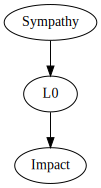

In [25]:
svg_str = graph.create_svg(prog='dot')
SVG(svg_str)

In [26]:
javabridge.detach()
javabridge.kill_vm()